In [1]:
# download from here https://github.com/bowang-lab/scGPT/tree/main?tab=readme-ov-file#pretrained-scGPT-checkpoints

import json
import os
import sys
import warnings

import torch
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp

import torchtext

torchtext.disable_torchtext_deprecation_warning()

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/home/dario/PycharmProjects/ML-lab/venv/lib/python3.12/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/dario/PycharmProjects/ML-lab/venv/lib/python3.12/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [2]:

set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

device = torch.device("cpu")


def preprocess_df(name, extension='csv'):
    csv_file = f'data/{name}.{extension}'
    df = pd.read_csv(csv_file)
    # remove is_true column
    df = df.drop(columns=['is_true', "Variant_Classification", "mutation"])
    # clip all values to positive
    df = df.clip(lower=0)
    # replace column names containing ".." with split[0] on ".."
    df.columns = [s.split("..")[0] for s in df.columns]

    # save to disk
    df.to_csv(f'data/{name}_processed_gpt.{extension}', index=False)


def load_model(model_dir="model_params"):
    # Specify model path; here we load the pre-trained scGPT blood model
    model_config_file = model_dir + "/args.json"
    model_file = model_dir + "/best_model.pt"
    vocab_file = model_dir + "/vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    # Retrieve model parameters from config files
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    print(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]

    ntokens = len(vocab)  # size of vocabulary
    model = TransformerModel(
        ntokens,
        embsize,
        nhead,
        d_hid,
        nlayers,
        vocab=vocab,
        pad_value=pad_value,
        n_input_bins=n_input_bins,
    )

    try:
        model.load_state_dict(torch.load(model_file, map_location=device))
        print(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file, map_location=device)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            print(f"Loading params {k} with shape {v.shape}")
            model_dict.update(pretrained_dict)
            model.load_state_dict(model_dict)

    model.to(device)
    gene2idx = vocab.get_stoi()

    return model, gene2idx, vocab_file


def load_and_preprocess(name, extension='csv'):
    adata = sc.read(f"data/{name}_processed_gpt.{extension}", cache=False)
    ori_batch_col = "batch"
    #adata.obs["celltype"] = adata.obs["final_annotation"].astype(str)
    data_is_raw = True

    # Preprocess the data following the scGPT data pre-processing pipeline
    preprocessor = Preprocessor(
        use_key="X",  # the key in adata.layers to use as raw data
        filter_gene_by_counts=3,  # step 1
        filter_cell_by_counts=False,  # step 2
        normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
        result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
        log1p=data_is_raw,  # 4. whether to log1p the normalized data
        result_log1p_key="X_log1p",
        subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
        hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
        binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
        result_binned_key="X_binned",  # the key in adata.layers to store the binned data
    )
    preprocessor(adata)
    return adata

In [3]:
# Load the pre-trained scGPT model and preprocess the data
model, gene2idx, vocab_file = load_model()
preprocess_df("CCLE_labels")
preprocess_df("TCGA_labels")

Resume model from model_params/best_model.pt, the model args will override the config model_params/args.json.
Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.l

In [4]:

# Load the preprocessed data
adataCCLE = load_and_preprocess("CCLE_labels")


scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...


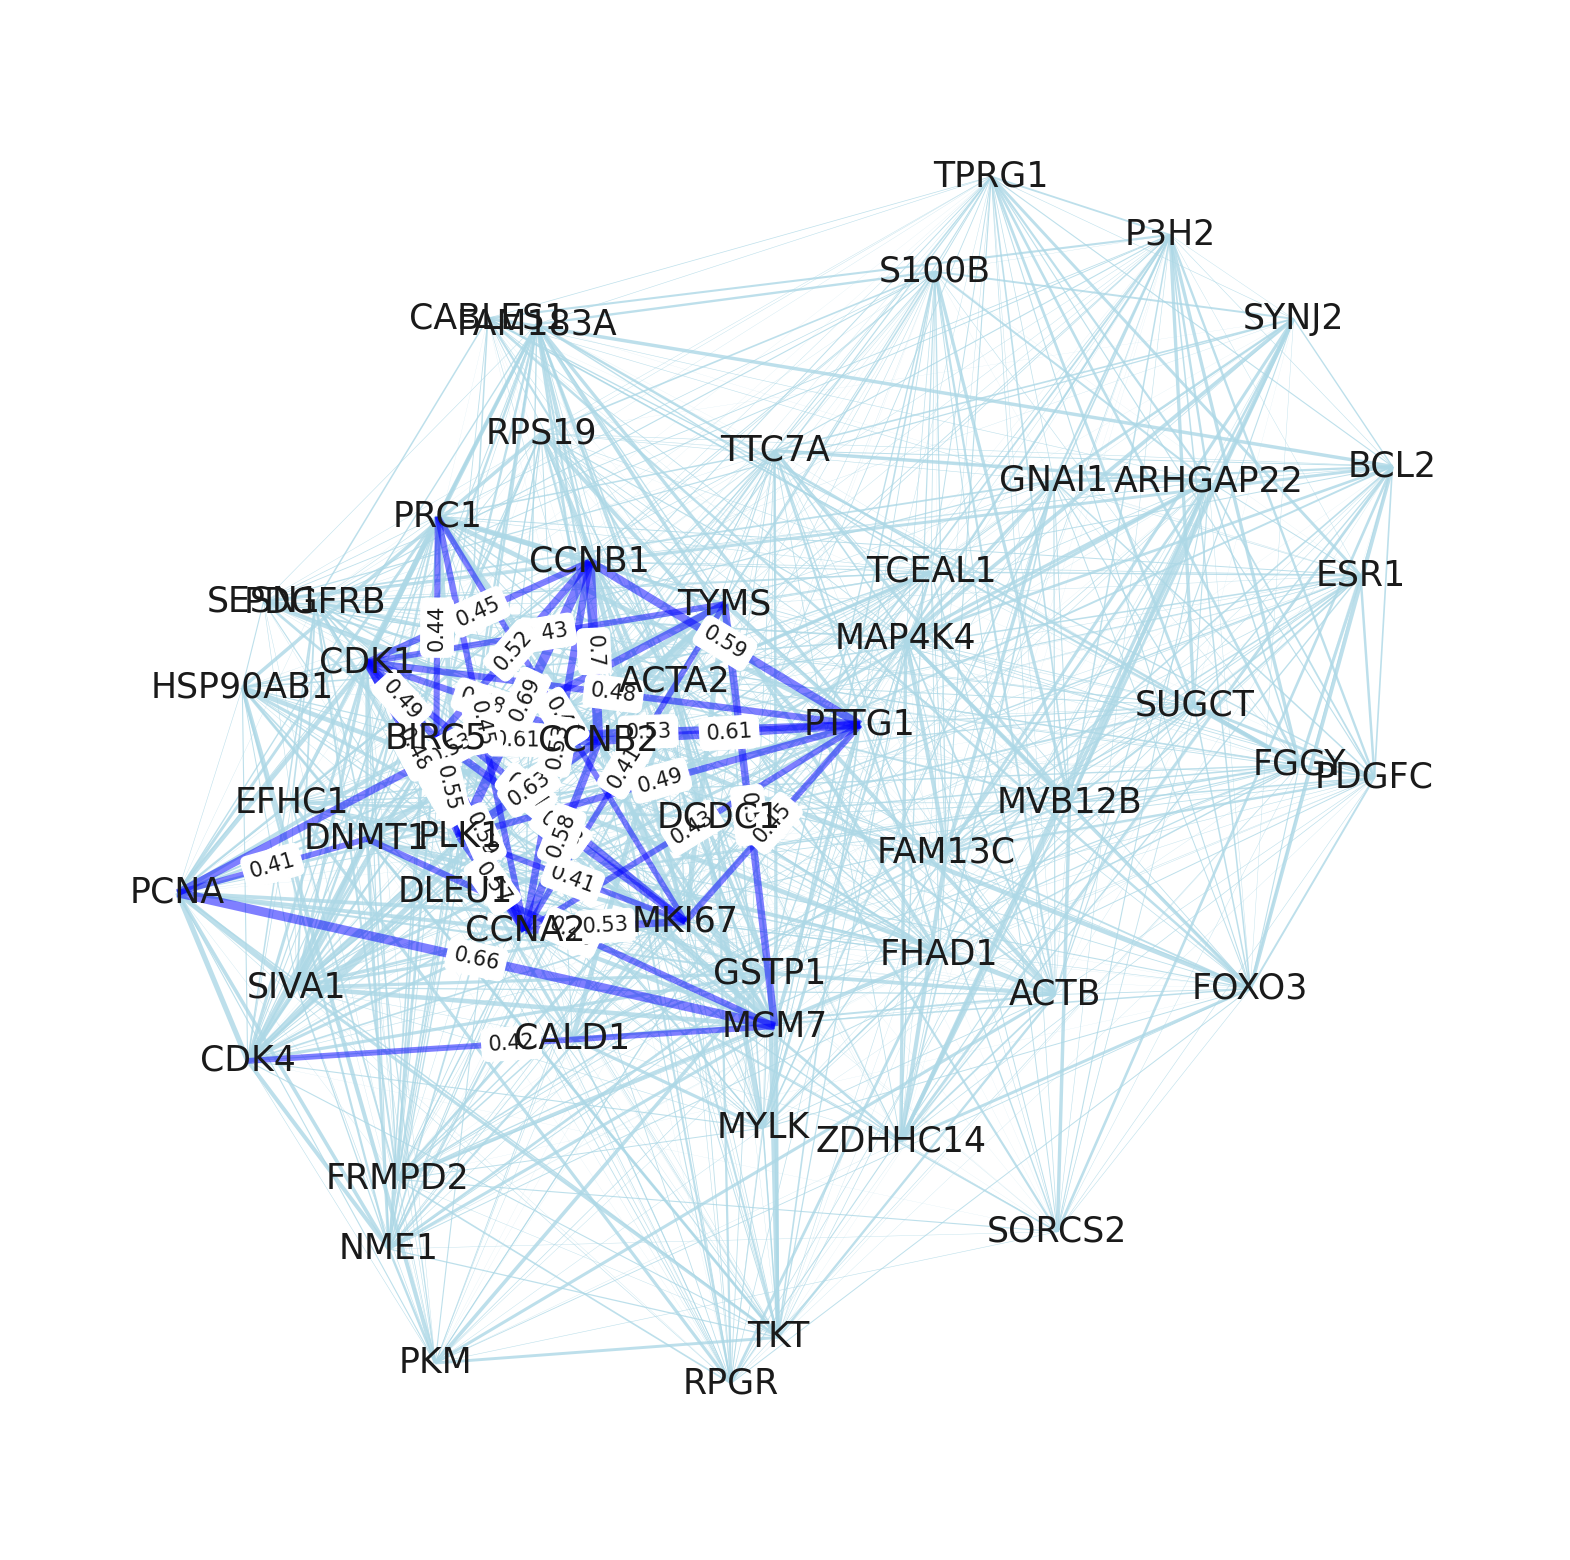

In [27]:
# Retrieve the data-independent gene embeddings from scGPT

def compute_gene_embeddings(gene2idx, adata):
    gene_ids = np.array([id for id in gene2idx.values()])
    gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
    gene_embeddings = gene_embeddings.detach().cpu().numpy()

    # Filter on the intersection between the Immune Human HVGs found in step 1.2 and scGPT's 30+K foundation model vocab
    gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if
                       gene in adata.var.index.tolist()}
    print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))
    return gene_embeddings


gene_embeddings = compute_gene_embeddings(gene2idx, adataCCLE)


def get_cell_embeddings(adata, gene_embeddings):
    # Calculate cell embeddings
    cell_embeddings_l = []
    for cell_idx in tqdm.tqdm(range(adataCCLE.shape[0])):
        cell_expression = adataCCLE[cell_idx].X.toarray().flatten()
        cell_embedding = np.zeros_like(next(iter(gene_embeddings.values())))

        for gene_idx, expression_level in enumerate(cell_expression):
            gene_name = adataCCLE.var.index[gene_idx]
            if gene_name in gene_embeddings:
                cell_embedding += gene_embeddings[gene_name] * expression_level

        cell_embeddings_l.append(cell_embedding)

    cell_embeddings = np.array(cell_embeddings_l)
    print('Computed embeddings for {} cells.'.format(cell_embeddings.shape[0]))
    return cell_embeddings


cell_embeddings = get_cell_embeddings(adataCCLE, gene_embeddings)

embed = GeneEmbedding(gene_embeddings)  # actually 545 genes long

# Perform Louvain clustering with desired resolution; here we specify resolution=40
gdata = embed.get_adata(resolution=30)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)
# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():

    if len(genes) > 4:
        mgs[mg] = genes
# Retrieve gene program 3 which contains the CD3 gene set
CD_genes = mgs['3']
print(CD_genes)
print(type(CD_genes))
CD_genes = [gene for mg, genes in mgs.items() for gene in genes]
# Compute cosine similarities among genes in this gene program
df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
for i in tqdm.tqdm(CD_genes):
    df = embed.compute_similarities(i, CD_genes)
    df['Gene1'] = i
    # this append does not work
    #df_CD = df_CD.append(df)

    df_CD = pd.concat([df_CD, df], ignore_index=True)

df_CD_sub = df_CD[df_CD['Similarity'] < 0.99].sort_values(by='Gene')  # Filter out edges from each gene to 
# Creates a graph from the cosine similarity network
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.4
lower_thresh = 0.
plt.figure(figsize=(20, 20))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v < lower_thresh:
        continue
    if v > thresh:
        width_large[list(widths.keys())[i]] = v * 10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0) * 10

nx.draw_networkx_edges(G, pos,
                       edgelist=width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos,
                       edgelist=width_large.keys(),
                       width=list(width_large.values()),
                       alpha=0.5,
                       edge_color="blue",
                       )
# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.show()



0.5351351351351351
0.7577807848443843


<Axes: >

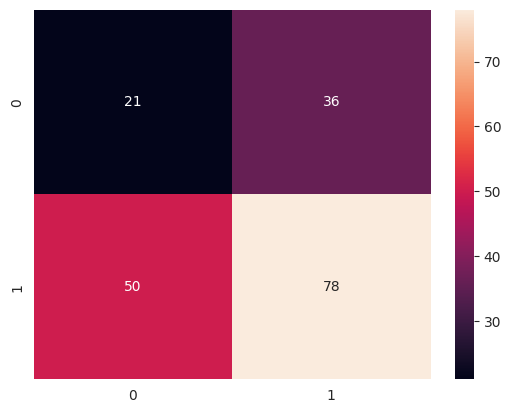

In [13]:

csv_file = 'data/CCLE_labels.csv'
df = pd.read_csv(csv_file)
y = df['mutation']
y = y.apply(lambda x: 1 if x == 'Missense_Mutation' else 0)

x = cell_embeddings

from sklearn.model_selection import train_test_split
# logit regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print(accuracy_score(y_test, y_pred))
print(accuracy_score(y_train, y_pred_train))
# confusion matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [29]:
cell_embeddings.shape

(4211, 512)